In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import joey as ml
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
batch_size = 4

In [4]:
transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])
trainset = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
dataiter = iter(trainloader)

In [5]:
images, labels = dataiter.next()
input_data = images.numpy()

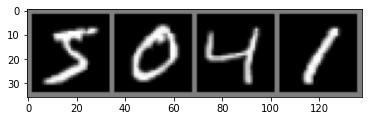

In [6]:
imshow(torchvision.utils.make_grid(images))

In [7]:
def backward_pass(input_data, expected_results):
    # Six 3x3 filters, activation RELU
    layer1 = ml.Conv(kernel_size=(6, 3, 3),
                     input_size=(batch_size, 1, 32, 32),
                     activation=ml.activation.ReLU(),
                     generate_code=False)
    # Max 2x2 subsampling
    layer2 = ml.MaxPooling(kernel_size=(2, 2),
                           input_size=(batch_size, 6, 30, 30),
                           stride=(2, 2),
                           generate_code=False)
    # Sixteen 3x3 filters, activation RELU
    layer3 = ml.Conv(kernel_size=(16, 3, 3),
                     input_size=(batch_size, 6, 15, 15),
                     activation=ml.activation.ReLU(),
                     generate_code=False)
    # Max 2x2 subsampling
    layer4 = ml.MaxPooling(kernel_size=(2, 2),
                           input_size=(batch_size, 16, 13, 13),
                           stride=(2, 2),
                           strict_stride_check=False,
                           generate_code=False)
    # Full connection (16 * 6 * 6 -> 120), activation RELU
    layer5 = ml.FullyConnected(weight_size=(120, 576),
                               input_size=(576, batch_size),
                               activation=ml.activation.ReLU(),
                               generate_code=False)
    # Full connection (120 -> 84), activation RELU
    layer6 = ml.FullyConnected(weight_size=(84, 120),
                               input_size=(120, batch_size),
                               activation=ml.activation.ReLU(),
                               generate_code=False)
    # Full connection (84 -> 10), output layer
    layer7 = ml.FullyConnectedSoftmax(weight_size=(10, 84),
                                      input_size=(84, batch_size),
                                      generate_code=False)
    # Flattening layer necessary between layer 4 and 5
    layer_flat = ml.Flat(input_size=(batch_size, 16, 6, 6),
                         generate_code=False)
    
    layers = [layer1, layer2, layer3, layer4,
              layer_flat, layer5, layer6, layer7]
    
    net = ml.Net(layers)
    outputs = net.forward(input_data)
    
    def loss_grad(layer, b):
        gradients = []
    
        for i in range(10):
            result = layer.result.data[i, b]
            if i == expected_results[b]:
                result -= 1
            gradients.append(result)
    
        return gradients
    
    net.backward(loss_grad)
    
    return (layer1, layer2, layer3, layer4, layer_flat, layer5, layer6, layer7)

In [8]:
layer1, layer2, layer3, layer4, layer_flat, layer5, layer6, layer7 = backward_pass(images, labels)

/home/maksymilian/Desktop/UROP/devito/devito/types/grid.py:206: RuntimeWarning: divide by zero encountered in true_divide
  spacing = (np.array(self.extent) / (np.array(self.shape) - 1)).astype(self.dtype)
Operator `Kernel` run in 0.01 s
Operator `Kernel` run in 0.01 s
Operator `Kernel` run in 0.01 s
Operator `Kernel` run in 0.01 s
Operator `Kernel` run in 0.01 s


PyTorch:

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [11]:
net = Net()
net.double()

with torch.no_grad():
    net.conv1.weight[:] = torch.from_numpy(layer1.kernel.data)
    net.conv1.bias[:] = torch.from_numpy(layer1.bias.data)
    net.conv2.weight[:] = torch.from_numpy(layer3.kernel.data)
    net.conv2.bias[:] = torch.from_numpy(layer3.bias.data)
    net.fc1.weight[:] = torch.from_numpy(layer5.kernel.data)
    net.fc1.bias[:] = torch.from_numpy(layer5.bias.data)
    net.fc2.weight[:] = torch.from_numpy(layer6.kernel.data)
    net.fc2.bias[:] = torch.from_numpy(layer6.bias.data)
    net.fc3.weight[:] = torch.from_numpy(layer7.kernel.data)
    net.fc3.bias[:] = torch.from_numpy(layer7.bias.data)

In [12]:
outputs = net(images.double())
net.zero_grad()
criterion = nn.CrossEntropyLoss()
loss = criterion(outputs, labels)
loss.backward()

In [13]:
layers = [layer1, layer3, layer5, layer6, layer7]
pytorch_layers = [net.conv1, net.conv2, net.fc1, net.fc2, net.fc3]

max_error = 0
index = -1

for i in range(5):
    kernel_grad = layers[i].kernel_gradients.data
    pytorch_kernel_grad = pytorch_layers[i].weight.grad.detach().numpy()
    
    kernel_error = abs(kernel_grad - pytorch_kernel_grad) / abs(pytorch_kernel_grad)
    
    bias_grad = layers[i].bias_gradients.data
    pytorch_bias_grad = pytorch_layers[i].bias.grad.detach().numpy()
    
    bias_error = abs(bias_grad - pytorch_bias_grad) / abs(pytorch_bias_grad)
    
    error = max(np.nanmax(kernel_error), np.nanmax(bias_error))
    print('layers[' + str(i) + '] maximum relative error: ' + str(error))
    
    if error > max_error:
        max_error = error
        index = i

print()
print('Maximum relative error is in layers[' + str(index) + ']: ' + str(max_error))

layers[0] maximum relative error: 1.599673499123359e-14
layers[1] maximum relative error: 5.710234136667345e-12
layers[2] maximum relative error: 1.9638017195468526e-11
layers[3] maximum relative error: 1.8676488586249282e-11
layers[4] maximum relative error: 3.4692340371450744e-13

Maximum relative error is in layers[2]: 1.9638017195468526e-11


<ipython-input-13-c5fd7a032cbe>:11: RuntimeWarning: invalid value encountered in true_divide
  kernel_error = abs(kernel_grad - pytorch_kernel_grad) / abs(pytorch_kernel_grad)
<ipython-input-13-c5fd7a032cbe>:16: RuntimeWarning: invalid value encountered in true_divide
  bias_error = abs(bias_grad - pytorch_bias_grad) / abs(pytorch_bias_grad)
